In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../src/simulator')
sys.path.insert(0, '../src/utils')

import config
config.jax_init()

import beam as beam_initialiser
import domain as d
import propagator as p
import diagnostics as diag
#import utils

import importlib
importlib.reload(beam_initialiser)
importlib.reload(d)
importlib.reload(p)
importlib.reload(diag)
#importlib.reload(utils)

import handle_filetypes as utilIO

import scipy.constants as sc

from pathlib import Path
home = str(Path.home())
sys.path.append(home + '/dev')

from imaging import Image # For semplicity, we use the Image method in MagPy Library (look on GitHub)


Initialising jax...

jax:    0.6.2
jaxlib: 0.6.2
numpy:  2.3.1
python: 3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:27:27) [GCC 11.2.0]
device info: cpu-16, 16 local devices"
process_count: 1
platform: uname_result(system='Linux', node='computer', release='5.15.179-1-MANJARO', version='#1 SMP PREEMPT Thu Mar 13 13:45:22 UTC 2025', machine='x86_64')

Default jax backend: cpu
Available devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11), CpuDevice(id=12), CpuDevice(id=13), CpuDevice(id=14), CpuDevice(id=15)]


In [2]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 5e-3

n_cells  = 100

probing_extent = extent_y
probing_direction = 'z'

domain = d.ScalarDomain(extent_x, n_cells)     # create domain

In [3]:
# load some external pvti
# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)
# or load a test distribution

sigma = -4e-3 #4 mm exponential growth rate
n_e0 = 2e17 * 1e6 #2e17 cm^-3 amplitude density
Ly = 1e-3 # 1 mm perturbation wavelength

domain.test_exponential_cos(n_e0 = n_e0, Ly = Ly, s = sigma)

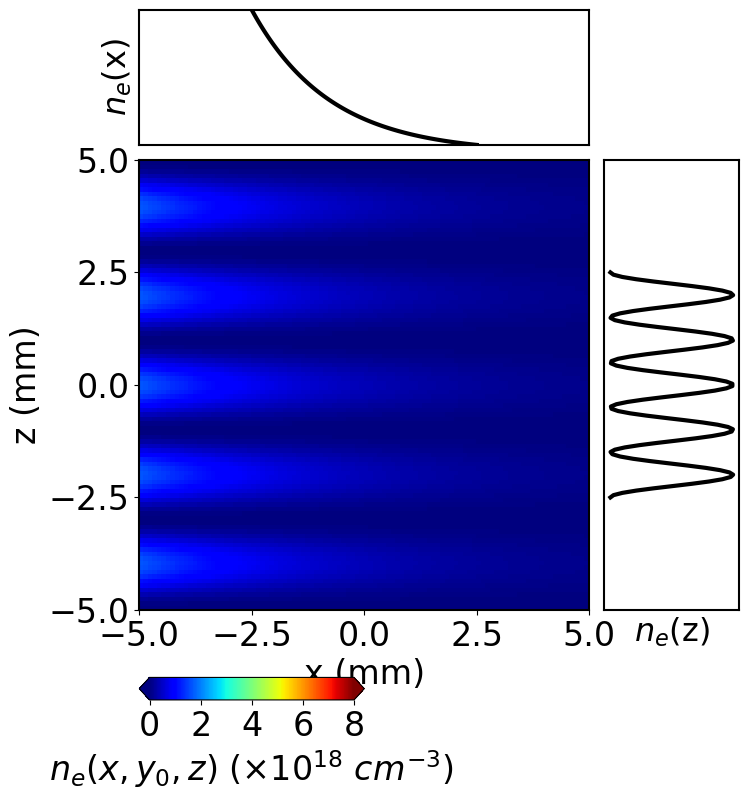

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize = (7.5, 7.5))
fig.subplots_adjust(.15, .15, .95, .95, hspace = 0.5)

im = ax.imshow(domain.ne[:,:,0].T / 1e24, cmap = 'jet', origin = 'lower', extent = [-5, 5, -5, 5], clim = [0, 8])

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

ax.set_xticks([-5, -2.5, 0, 2.5, 5])
ax.set_yticks([-5, -2.5, 0, 2.5, 5])

axins1 = inset_axes(
    ax,
    width = "50%",  # width: 50% of parent_bbox width
    height = "5%",  # height: 5%
    loc = "lower right",
    bbox_to_anchor = (-0.5, -0.2, 1, 1),
    bbox_transform = ax.transAxes,
    borderpad = 0,
)

axins1.xaxis.set_ticks_position("bottom")
cbar = plt.colorbar(im, cax = axins1, ticks=[0, 2, 4, 6, 8], shrink = 0.4, orientation = "horizontal", extend = 'both')
cbar.set_label(r'$ n_e(x, y_0, z)$ ($\times 10^{18}$ $cm^{-3}$)', fontsize = 24)
cbar.ax.tick_params(labelsize = 24)

ax.set_xlabel('x (mm)', fontsize = 24)
ax.set_ylabel('z (mm)', fontsize = 24)

divider = make_axes_locatable(ax)
axvert = divider.append_axes('right', size='30%', pad=0.15)
axhoriz = divider.append_axes('top', size='30%', pad=0.15)

profile_vert = domain.ne[:,:,0].T.sum(axis = 0)
profile_vert = (profile_vert - profile_vert.min() ) / (profile_vert.max() - profile_vert.min())
axhoriz.plot(domain.x, profile_vert, lw = 3, c = 'k', alpha = 1)
axhoriz.set_xlim(-5e-3, 5e-3)
axhoriz.set_ylim(0, 1)
axhoriz.set_ylabel(r'$n_e$(x)', fontsize = 23)


profile_hor     =   domain.ne[:,:,0].T.sum(axis = 1)
profile_hor     =   (profile_hor - profile_hor.min() ) / (profile_hor.max() - profile_hor.min())
profile_hor_theory  =  profile_hor
axvert.plot(profile_hor, domain.y, lw = 3, c = 'k', alpha = 1)
axvert.set_ylim(-5e-3,5e-3)
axvert.set_xlabel(r'$n_e$(z)', fontsize = 23)

ax.tick_params(axis = 'both', labelsize = 24)

axvert.set_xticks([])
axhoriz.set_yticks([])
axvert.set_yticks([])
axhoriz.set_xticks([])

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)
    axvert.spines[axis].set_linewidth(1.5)
    axhoriz.spines[axis].set_linewidth(1.5)

# ax.text(4, 4.2, s = 'a)', c = 'w', fontsize = 30)


# save Figure
# fig.savefig('./analytical 2D electron density distribution.png', bbox_inches='tight', dpi=600)

In [5]:
# initialise beam
lwl = 1064e-9 #define laser wavelength
Np = 1000000   #number of photons
divergence = 5e-5 #realistic divergence value
beam_size = [extent_x, extent_z]    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'rectangular'

beam = beam_initialiser.Beam(Np = Np, beam_size = beam_size, divergence = divergence, ne_extent = ne_extent, beam_type = beam_type, probing_direction = probing_direction)

tracer = p.Propagator(domain, probing_direction = probing_direction, phaseshift = True)

# solve ray trace
tracer.calc_dndr(lwl)
final_rays_e, E = tracer.solve(beam.s0, return_E = True, memory_debug = False)


Size in memory of initial rays: 712B
Predicted size in memory of domain: 3.814697265625 MB

Running device: cpu, with: 16 cores.
NamedSharding(mesh=Mesh('cols': 16, axis_types=(Auto,)), spec=PartitionSpec(None, 'cols'), memory_kind=unpinned_host)

jax compilation of solver took: 0.0003495216369628906 seconds

Parallelised output has resulting 3D matrix of form: [batch_count, 2, 9]: (100000, 2, 9)
	2 to account for the start and end results
	9 containing the 3 position and velocity components, amplitude, phase and polarisation
	If batch_count is lower than expected, this is likely due to jax's forced integer batch sharding when parallelising over cpu cores.

We slice the end result and transpose into the form: (9, 100000) to work with later code.



rf size expected: (100000, 100000)
rf after clearing nan's: (100000, 100000)


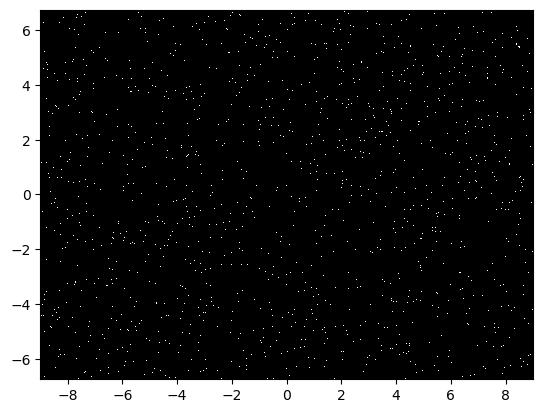

In [15]:
sh_e = diag.Shadowgraphy(lwl, final_rays_e, Jf = E, R = 25, focal_plane = 0, L = 400)
sh_e.single_lens_solve()
sh_e.histogram(bin_scale = 1, clear_mem = False)

sh_e.plot(plt, clim = [0, 0.5], cmap = 'gray')


rf size expected: (100000, 100000)
rf after clearing nan's: (100000, 100000)


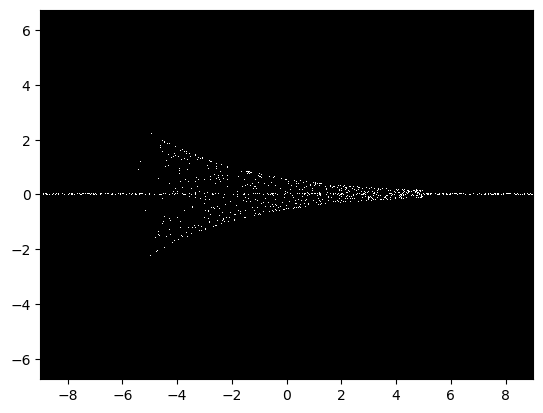

In [14]:
# Jf can be passed by name or position
rh_e = diag.Refractometry(lwl, final_rays_e, E, R = 25, focal_plane = 0, L = 400)
rh_e.incoherent_solve()
rh_e.histogram(bin_scale = 1, clear_mem=False)

rh_e.plot(plt, clim = [0, 0.5], cmap = 'gray')

In [ ]:
# final_E = s.interfere_ref_beam(final_rays_e, E, n_fringes, deg)
# ih = diag.Interferometry(final_rays_e, E = final_E, R = 25, focal_plane = 0, L = 400)
# ih.two_lens_solve(lwl)
# ih.interferogram(bin_scale = 1, clear_mem = True)

#ih.plot(plt, clim=[0, 0.5], cmap = 'gray')


rf size expected: (100000, 100000)
rf after clearing nan's: (100000, 100000)


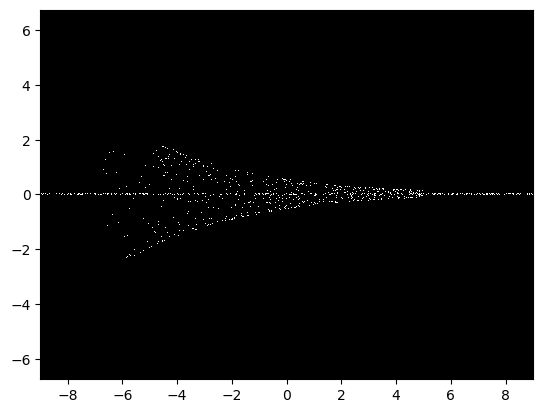

In [16]:
rh_ec = diag.Refractometry(lwl, final_rays_e, E, R = 25, focal_plane = -100, L = 400)
rh_ec.coherent_solve()
#rh_ec.refractogram(bin_scale = 1, clear_mem=True)
rh_ec.histogram(bin_scale = 1, clear_mem=True)

rh_ec.plot(plt, clim=[0, 0.5], cmap = 'gray')
#plt.imshow(rh_ec.H, clim=[0,0.5], cmap = 'gray')
# plt.xlim([1630,1820])
# plt.ylim([1100,1500])

From pixel to Real Units - Data Post Processing

In [ ]:
scale_sh_x   =  sh_e.H.shape[1]/9
scale_sh_y   =  sh_e.H.shape[0]/6.75

L = 400 # distance from the volume to the lens (for a single lens system - 300 mm)

pixel_size  = (13.5/rh_e.H.shape[0])  # pixel size, mm/px in this case because bin = 10, pixel size = 52 um instead 5.4 um
scale_phi   =   1/(2 * pixel_size/L * 1000)  #sensitivity is Lϕ/2, ϕ in radians, convert to mradians.


shadow_sh  =     Image(sh_e.H, 0, scale_sh_x, scale_sh_y, fliplr = True)
o_sh       =     (int(sh_e.H.shape[1]/2), int(sh_e.H.shape[0]/2))
shadow_sh.set_origin(o_sh)

refr_sh    =     Image(rh_e.H, 0., scale_sh_x, scale_phi, fliplr = False)
o_rh       =       (int(rh_e.H.shape[1]/2), int(rh_e.H.shape[0]/2))
refr_sh.set_origin(o_rh)

refr_sh_c    =     Image(rh_ec.H, 0., scale_sh_x, scale_phi, fliplr = False)
o_rh_c       =       (int(rh_ec.H.shape[1]/2), int(rh_ec.H.shape[0]/2))
refr_sh_c.set_origin(o_rh_c)



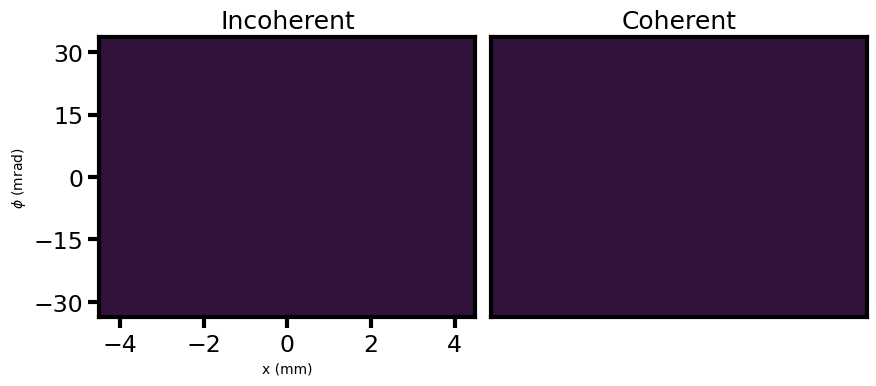

In [ ]:
aspect  = scale_phi / scale_sh_x
titles  = ['Incoherent','Coherent']
fig = plt.figure(figsize=(20, 10))
outer_grid = fig.add_gridspec(1, 4, wspace=0.04, hspace = 0.0005)

for i, rh in enumerate([refr_sh, refr_sh_c]):
    axis =  fig.add_subplot(outer_grid[0, i])
    rh.plot_mm(axis, multiply_by = 1, aspect  = aspect, cmap = 'turbo', clim = [0.03,0.4])
    axis.grid(False)
    if i == 0:
        axis.set_xlabel('x (mm)')
        axis.set_ylabel(r"$\phi$ (mrad)")
        axis.set_yticks([-30, -15, 0, 15, 30])
        axis.set_xlim(-4.5,4.5)   
        # for c, src in enumerate([-0.5, 0.25, 1.]):
        #     arrow = FancyArrowPatch((src, 23), (src, 15), arrowstyle='->', color = color[c], linewidth=3, linestyle='-', mutation_scale=25)
        #     axis.add_patch(arrow)
    else:
        axis.set_xticks([])
        axis.set_yticks([])

    axis.set_title(titles[i], size = 18)
    axis.tick_params(axis="both", which="major", labelsize=17, width = 3, length = 8)
    for ax in ["top", "bottom", "left", "right"]:
        axis.spines[ax].set_linewidth(3)